## 正则化

### 需要导入的库


In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
#需要的基础函数如下：
def initialize_parameters(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))


    return parameters

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s



def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of n_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def compute_loss(a3, Y):
    
    """
    Implement the loss function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    loss - value of the loss function
    """
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=np.squeeze(train_Y), s=40, cmap=plt.cm.Spectral);

    return train_X, train_Y, test_X, test_Y

### 问题的描述

守门员发球门球，应该踢给哪个队员，才能最大的概率让本方球员拿到。

下图的说明
- 蓝色的点，本方球员获得
- 红色的点，对方球员获得


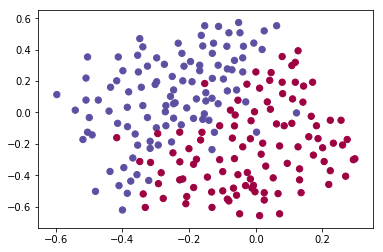

In [3]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

### 模型创建

这里将创建一个3层的网络，之前的课程已经介绍过了，主要针对不同的正则化方法：

- L2正则化,需要重新更新的函数
    - compute_cost_with_regularization()
    - backward_propagation_with_regularization()
- dropout，需要重新更新的函数
    - forward_propagation_with_dropout()
    - backward_propagation_with_dropout()
    
具体的coding如下:

In [13]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0],20,3,1]
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0,num_iterations):
        
        # 前向传播：LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3,cache = forward_propagation(X,parameters)
        elif keep_prob <1:
            a3,cache = forward_propagation_with_dropout(X, parameters, keep_prob)
            
        # 损失函数
        if lambd == 0:
            cost = compute_cost(a3,Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X,Y,cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X,Y,cache,lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X,Y,cache,keep_prob)
            
         # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters
        

### 无正则化的模型
只需要使用默认的参数即可构建无正则化的模型.

通过模型训练和测试我们可以获得结果如下：
- 训练的精度为94.8%，测试精度91.5%
- 从绘制的图中可以看到该模有一点过拟合。

下面我们需要使用正则化来消除这样的过拟合的情况。


Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572419
Cost after iteration 20000: 0.13851642423239133


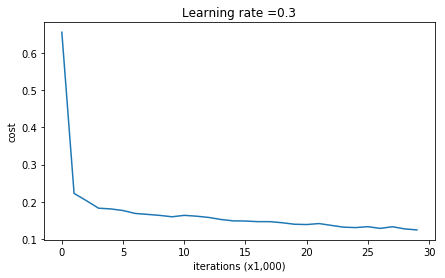

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [10]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

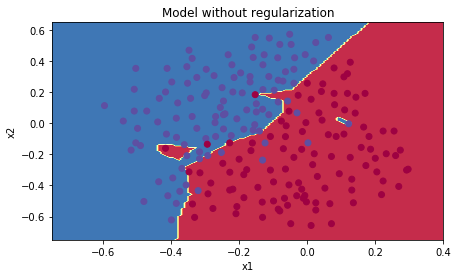

In [11]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), 
                        train_X, np.squeeze(train_Y))

### L2 正则化

下面来看看正则化的公式：

![](imgs/1.jpg)

![](imgs/2.jpg)

为了计算后面的正则化项，我们可以使用如下函数：
`np.sum(np.square(Wl))`

如果是有三层，则需要将三层的$W^{[1]},W^{[2]},W^{[3]}$都要叠加到一起。

具体的函数如下：

In [6]:

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost

    L2_regularization_cost = (1./m*lambd/2)*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [7]:
# 测试函数
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))


cost = 1.7864859451590758


上面我更新了新的loss函数，这里我们需要将反向传播的函数也一起跟着修改。这里我们需要注意的一点是：因为上面的loss函数只是对W做了范数叠加，所以这里我们只需要在W的梯度进行修正。其梯度为：

$\frac d{dW}(\frac 12\frac {\lambda}mW^2)=\frac {\lambda}mW$

这里仅仅需要对W这一项进行修正，因为在计算梯度求导的时候，会将其他项忽略掉。
具体的coding如下：

In [10]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    # 需要加入修正项目
    dW3 = 1./m * np.dot(dZ3,A2.T) + lambd/m * W3
    db3 = 1./m * np.sum(dZ3,axis=1,keepdims = True)
    
    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2,np.int64(A2>0))
    dW2 = 1./m * np.dot(dZ2,A1.T)+lambd/m * W2
    db2 = 1./m * np.sum(dZ2,axis=1,keepdims = True)
    
    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1>0))
    dW1 = 1./m * np.dot(dZ1,X.T) + lambd/m * W1
    db1 = 1./m * np.sum(dZ1,axis=1,keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

In [11]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


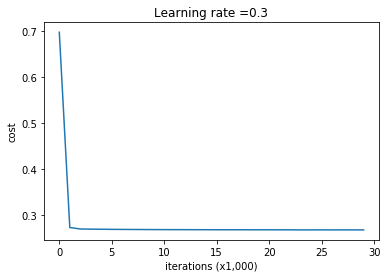

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [16]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

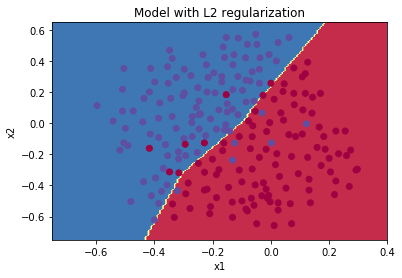

In [17]:
plt.title("Model with L2 regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), 
                        train_X, np.squeeze(train_Y))

从上面的图中可以得到：
- 在损失函数中添加了$\lambda$超参数
- L2 正则化化后，结果更加平滑，缓解了过拟合的现象

为什么正则化可以有效的缓解过拟合的现象
- 假设更少的权重的模型比更大权重的模型更加简单
- 所以通过在损失函数中添加一个权重的惩罚值，让权重变小
- 在每一层求解梯度值得时候，都会将该惩罚值添加到每一个权重中去
- $W = W -\alpha (dW+\frac {\lambda}mW)$
    - 惩罚值越大$\frac {\lambda}mW$，W就越小


### Dropout

Dropout广泛用在深度学习得模型中，其基本做法就是：
- 在每一次训练的过程中随机的让以下神经网络的节点失效

为什么这样的方式起作用：
- 因为是在每次迭代训练的过程中，随机的关闭一些节点
- 这样就可以防止某些节点具有更小的灵敏度，让所有的节点的权重都能均等的获得某些信息，让其权重更加分散。防止过拟合

#### 前向传播中的dropout

这里我们需要处理的是一个三层的模型，一般在输出层最后一层我们不使用dropout，具体的步骤如下：

- 创建一个随机值d,该随机值的shape与a的一样
- 将d中的值与keep_prob进行比较，获得一个标志位，这样就可以知道那些节点失效
- 将a= a\*d,获得最终的有效的节点和无效的节点
- a= a/keep_prob,保证损失值得期望值


In [4]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    np.random.seed(1)

    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    # 开始执行dropout
    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    D1 = D1 < keep_prob
    A1 = A1 * D1
    A1 = A1/keep_prob
    
    Z2 = np.dot(W2,A1) + b2
    A2 = relu(Z2)
    # 开始执行dropout
    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = D2 < keep_prob
    A2 = A2 * D2
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3,A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache
    
    
    
    

In [27]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


#### dropout的反向传播

反向传播的过程中，只要将前向传播中的失效的节点，继续让其失效即可。具体步骤如下：

- 将前向传播中的失效的节点，继续让其失效 D * A
- 由于前向传播中，A1/keep_prob,所以在反向传播中也需要将da/keep_prob

In [10]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3,A2.T) 
    db3 = 1./m * np.sum(dZ3,axis=1,keepdims=True)
    dA2 = np.dot(W3.T,dZ3)
    
    #需要让一些节点失效
    dA2 = dA2 * D2
    dA2 = dA2/keep_prob
    dZ2 = np.multiply(dA2,np.int64(A2>0))
    dW2 = 1./m * np.dot(dZ2,A1.T) 
    db2 = 1./m * np.sum(dZ2,axis=1,keepdims=True)
    
    
    dA1 = np.dot(W2.T,dZ2)
    dA1 = dA1 * D1
    dA1 = dA1/keep_prob
    dZ1 = np.multiply(dA1,np.int64(A1>0))
    dW1 = 1./m * np.dot(dZ1,X.T) 
    db1 = 1./m * np.sum(dZ1,axis=1,keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients
    

In [11]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0: 0.6543912405149825


D:\Study\python\jupyter\DeepLearning\AndrewCourse\2_Optimizer\WK01\reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
D:\Study\python\jupyter\DeepLearning\AndrewCourse\2_Optimizer\WK01\reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.061016986574905605
Cost after iteration 20000: 0.060582435798513114


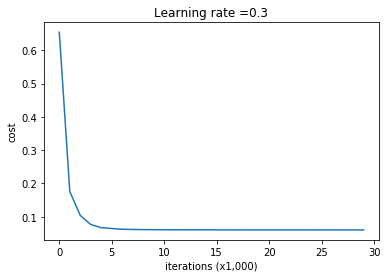

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [14]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

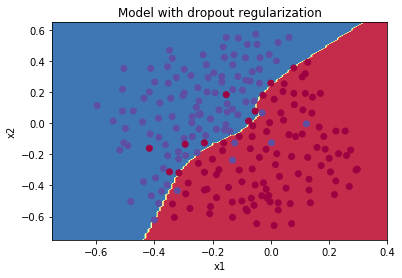

In [15]:
plt.title("Model with dropout regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), 
                        train_X, np.squeeze(train_Y))